<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone Project: 2.1 Modelling - Race Classification

> Authors: Pius Yee

##### In this Notebook 2.1, I will proceed to build the model for Race Classification.

### Import libraries

In [2]:
import os
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.image import imread
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras
from keras_vggface.vggface import VGGFace
from keras.applications.resnet import ResNet50

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, auc, classification_report 


## 1. Importing images for model training

In [3]:
# Import dataframe from the previous notebook

df_main = pd.read_csv("../datasets/df_main.csv",index_col=0)
df_main

,filename,age,gender,race,age_range
0,9_1_2_20161219204347420.jpg.chip.jpg,9,Female,Asian,0-10
1,36_0_1_20170117163203851.jpg.chip.jpg,36,Male,Black,31-40
2,86_1_0_20170120225751953.jpg.chip.jpg,86,Female,White,71-120
3,26_1_0_20170116171048641.jpg.chip.jpg,26,Female,White,21-30
4,1_1_2_20161219154612988.jpg.chip.jpg,1,Female,Asian,0-10
...,...,...,...,...,...
23702,35_0_0_20170117155112202.jpg.chip.jpg,35,Male,White,31-40
23703,52_0_3_20170119200211340.jpg.chip.jpg,52,Male,Indian,51-60
23704,26_0_1_20170116010114628.jpg.chip.jpg,26,Male,Black,21-30
23705,28_0_1_20170117015458481.jpg.chip.jpg,28,Male,Black,21-30


##### Similar to the previous model for gender prediction, I will manually create a new column for train-test splitting in the dataframe instead of using the train-test split library. The reason for this approach is that I will use the flow-from-dataframe method to import images, making it easier to manually split the train and test data.

In [4]:
# Manually create a train-test split column in the dataframe, with 80% for train and 20% for test.
np.random.seed(39)
df_main['train_test'] = np.random.choice([0, 1], size=len(df_main), p=[0.8,0.2],)
df_main

,filename,age,gender,race,age_range,train_test
0,9_1_2_20161219204347420.jpg.chip.jpg,9,Female,Asian,0-10,0
1,36_0_1_20170117163203851.jpg.chip.jpg,36,Male,Black,31-40,0
2,86_1_0_20170120225751953.jpg.chip.jpg,86,Female,White,71-120,1
3,26_1_0_20170116171048641.jpg.chip.jpg,26,Female,White,21-30,0
4,1_1_2_20161219154612988.jpg.chip.jpg,1,Female,Asian,0-10,0
...,...,...,...,...,...,...
23702,35_0_0_20170117155112202.jpg.chip.jpg,35,Male,White,31-40,0
23703,52_0_3_20170119200211340.jpg.chip.jpg,52,Male,Indian,51-60,0
23704,26_0_1_20170116010114628.jpg.chip.jpg,26,Male,Black,21-30,1
23705,28_0_1_20170117015458481.jpg.chip.jpg,28,Male,Black,21-30,1


##### For importing the images, I will use ImageDataGenerator from Keras. It not only help to rescale the training images, but also do augmentation for the images.

##### In this case, I used the following augmentations:

- `width_shift_range=0.2:` Randomly shifts the image horizontally along the width by up to 20% of the total width, enhancing model robustness to object position variations.

- `height_shift_range=0.2:` Randomly shifts the image vertically along the height by up to 20% of the total height, similar to the width shift but in the vertical direction.

- `shear_range=0.2:` Applies a shear transformation, slanting the image along one axis, helping simulate perspective changes.

- `zoom_range=0.2:` Randomly zooms the image in or out by up to 20%, making the model more resilient to changes in the object's apparent size.

- `horizontal_flip=True:` Randomly flips the image horizontally (like looking in a mirror), helping prevent the model from developing biases based on left/right orientation.

- `fill_mode='nearest':` Specifies how to fill in newly created pixels at the image edges after transformations (shifts, shears, etc.), using the nearest pixel value to preserve the image's overall structure.

In [5]:
# Create an ImageDataGenerator for training images (with augmentation)
datagen_train = ImageDataGenerator(   # for train data
        rescale=1.0/255.0,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# Create an ImageDataGenerator for validation images (without augmentation)
datagen_val = ImageDataGenerator(   # for validation data
        rescale=1.0/255.0)

##### Import the images with the newly created ImageDataGenerator

In [6]:
# Set up your data flow using flow_from_dataframe
train_data = datagen_train.flow_from_dataframe(
    dataframe=df_main[df_main.train_test == 0],
    directory='../datasets/utkface',
    x_col='filename',
    y_col='race',
    target_size=(224,224),
    class_mode='categorical')  # Use 'raw' for multi-output models

val_data = datagen_val.flow_from_dataframe(
    dataframe=df_main[df_main.train_test == 1],
    directory='../datasets/utkface',
    x_col='filename',
    y_col='race',
    target_size=(224,224),
    class_mode='categorical')  # Use 'raw' for multi-output models

Found 18981 validated image filenames belonging to 5 classes.
Found 4726 validated image filenames belonging to 5 classes.


##### The data consists of 5 classes of race below:.

In [19]:
# check the classes for imported data
train_data.class_indices

{'Asian': 0, 'Black': 1, 'Indian': 2, 'Others': 3, 'White': 4}

## 2. Setting up the models

##### For the models, I will use 3 different models as baselines to determine which one yields the best result. I will then select the best-performing model for further tuning.

##### The 3 models are:
- Keras CNN (without pre-trained model)
- VGGFace
- ResNet

### 2.1 Keras CNN (without pre-trained model)

##### Setting up the model architecture

In [8]:
model_cnn = Sequential()

# Add a convolutional layer to the instantiated empty model.
# Conv2D for 2-D convolution on image
model_cnn.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))

# EVERY convolution layer is followed by a pooling layer.
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

# more layers
model_cnn.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

# Add some fully connected layers once having 1-D vector from 'Flatten()'
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(5, activation='softmax')) # Output layer

# show the summary
model_cnn.summary()

2024-05-03 00:22:51.149549: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-03 00:22:51.149614: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-05-03 00:22:51.149623: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-05-03 00:22:51.149902: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-03 00:22:51.150381: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 128)               1

In [9]:
# Compile model.
opt = Adam(learning_rate=0.001) # create Adam optimizer with 1e-3 learning rate
model_cnn.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [10]:
# Fit model on training data (fit model and save results to history)
history_cnn = model_cnn.fit(train_data, # train_data created using ImageDataGenerator class for model training
                        batch_size=64,
                        validation_data=val_data, # val_data created using ImageDataGenerator class for model validation
                        epochs=5,
                       )

Epoch 1/5


2024-05-03 00:22:51.932611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


594/594 [==============================] - 114s 186ms/step - loss: 1.5536 - accuracy: 0.4191 - val_loss: 1.3774 - val_accuracy: 0.4543
Epoch 2/5
594/594 [==============================] - 129s 217ms/step - loss: 1.4132 - accuracy: 0.4419 - val_loss: 1.4438 - val_accuracy: 0.4592
Epoch 3/5
594/594 [==============================] - 138s 232ms/step - loss: 2.8220 - accuracy: 0.3664 - val_loss: 7.2633 - val_accuracy: 0.2992
Epoch 4/5
594/594 [==============================] - 141s 237ms/step - loss: 12.3582 - accuracy: 0.3004 - val_loss: 24.6766 - val_accuracy: 0.1991
Epoch 5/5
594/594 [==============================] - 162s 273ms/step - loss: 30.9745 - accuracy: 0.3141 - val_loss: 27.5056 - val_accuracy: 0.2262


##### The results are as follows:-

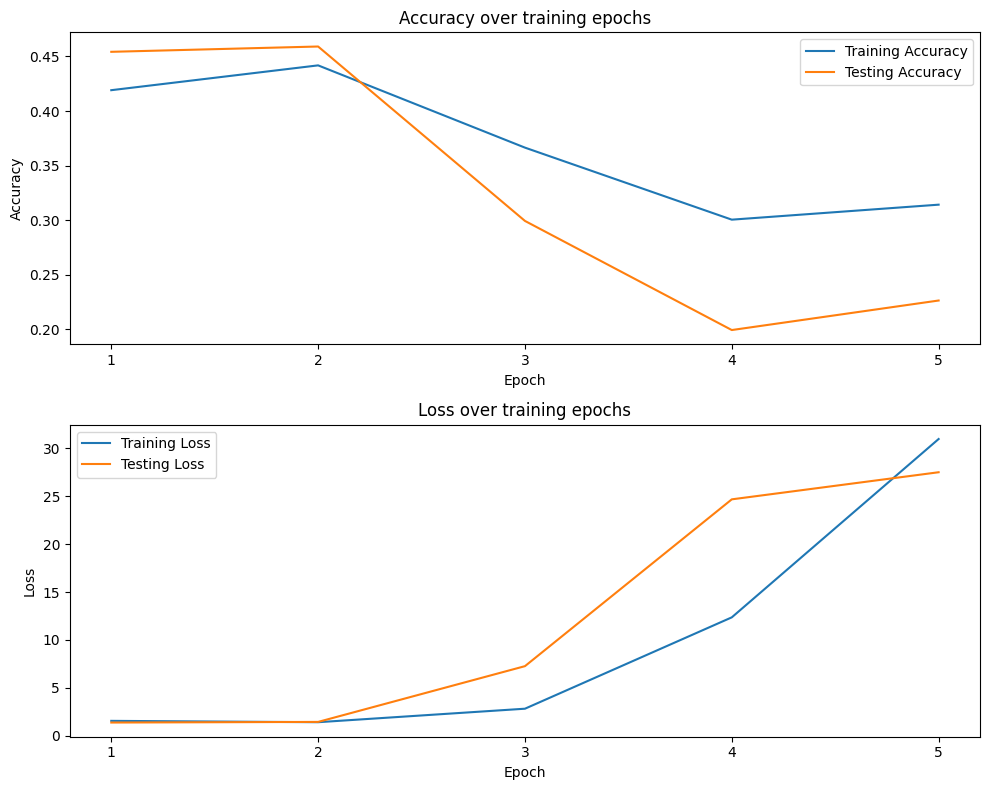

In [4]:
# Check out the train loss and test loss over epochs.
train_loss_cnn = history_cnn.history['loss']
test_loss_cnn = history_cnn.history['val_loss']
train_acc_cnn = history_cnn.history['accuracy']
test_acc_cnn = history_cnn.history['val_accuracy']

# Set figure size.
fig, axes = plt.subplots(nrows=2, figsize=(10,8))

# Generate line plot of training, testing loss over epochs.
axes[0].plot(train_acc_cnn, label='Training Accuracy')
axes[0].plot(test_acc_cnn, label='Testing Accuracy')
axes[0].set_title("Accuracy over training epochs")
axes[0].legend();
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(np.arange(len(test_acc_cnn)), np.arange(1, len(test_acc_cnn)+1))

axes[1].plot(train_loss_cnn, label='Training Loss')
axes[1].plot(test_loss_cnn, label='Testing Loss')
axes[1].set_title("Loss over training epochs")
axes[1].legend();
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_xticks(np.arange(len(test_acc_cnn)), np.arange(1, len(test_acc_cnn)+1))

# Set title
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

##### The accuracy is decreasing and loss is increasing with the training epochs, suggesting the model is not improving.

##### We proceed to the next model.

### 2.2 VGGFace (Transfer learning from Pre-trained model)

##### Import the pre-trained model

In [12]:
# Import the desired pre-trained transfer learning model: VGGFace
pre_trained_vgg = VGGFace(model='vgg16', include_top=False, input_shape=(224,224,3))

# Freeze the model so we don't accidentally change the pre-trained model parameters during dense layer gradient descent
for layer in pre_trained_vgg.layers:
  layer.trainable = False

##### Setting up the model architecture

In [13]:
model_vgg = Sequential()

# Add the pretrained mdoel
model_vgg.add(pre_trained_vgg)

# Flatten the pre-trained output
model_vgg.add(Flatten())

# Add dense layers
model_vgg.add(Dense(128, activation='relu'))
model_vgg.add(Dense(64, activation='relu'))
model_vgg.add(Dense(5, activation='softmax')) # Output layer

# show the summary
model_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vggface_vgg16 (Functional)  (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               3211392   
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 5)                 325       
                                                                 
Total params: 17,934,661
Trainable params: 3,219,973
Non-trainable params: 14,714,688
_________________________________________________________________


In [14]:
# Compile model.
opt = Adam(learning_rate=0.001) # create Adam optimizer with 1e-3 learning rate
model_vgg.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [15]:
# Fit model on training data (fit model and save results to history)
history_vgg = model_vgg.fit(train_data, # train_data created using ImageDataGenerator class for model training
                        batch_size=64,
                        validation_data=val_data, # val_data created using ImageDataGenerator class for model validation
                        epochs=5,
                       )

Epoch 1/5
594/594 [==============================] - 531s 892ms/step - loss: 0.7047 - accuracy: 0.7661 - val_loss: 0.5486 - val_accuracy: 0.8157
Epoch 2/5
594/594 [==============================] - 588s 990ms/step - loss: 0.6007 - accuracy: 0.8000 - val_loss: 0.5836 - val_accuracy: 0.8176
Epoch 3/5
594/594 [==============================] - 723s 1s/step - loss: 0.5926 - accuracy: 0.8044 - val_loss: 0.5720 - val_accuracy: 0.8017
Epoch 4/5
594/594 [==============================] - 1046s 2s/step - loss: 0.6096 - accuracy: 0.8014 - val_loss: 0.5539 - val_accuracy: 0.8240
Epoch 5/5
594/594 [==============================] - 1017s 2s/step - loss: 0.6204 - accuracy: 0.7993 - val_loss: 0.6080 - val_accuracy: 0.8043


##### The results are as follows:-

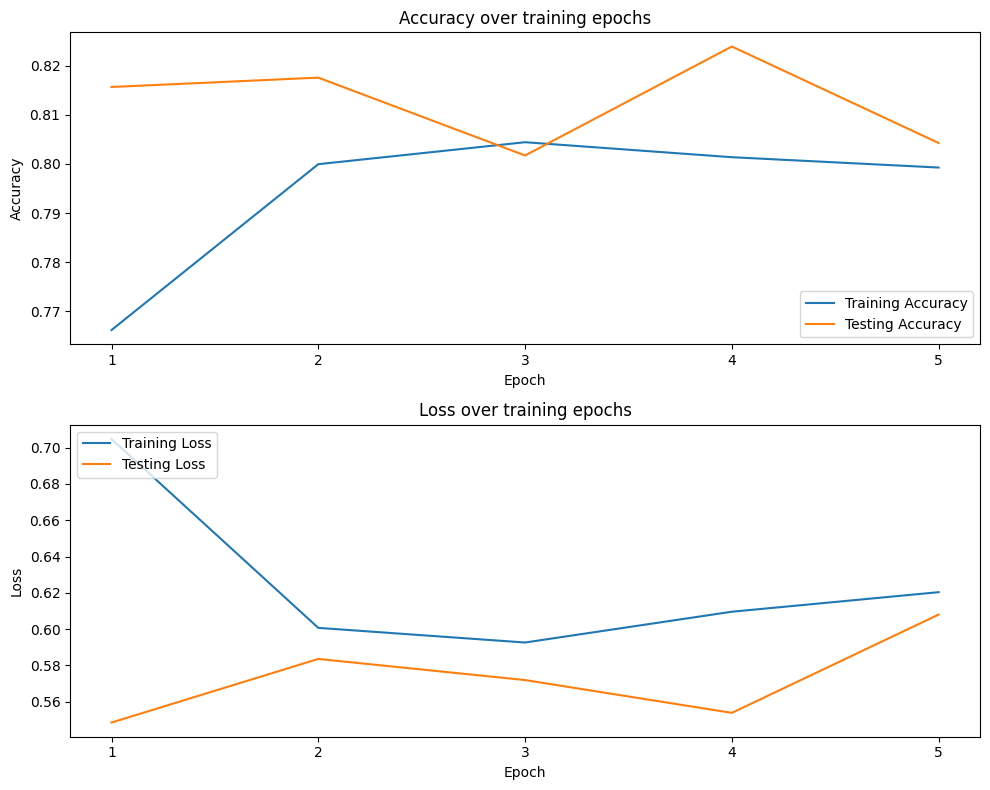

In [5]:
# Check out our train loss and test loss over epochs.
train_loss_vgg = history_vgg.history['loss']
test_loss_vgg = history_vgg.history['val_loss']
train_acc_vgg = history_vgg.history['accuracy']
test_acc_vgg = history_vgg.history['val_accuracy']

# Set figure size.
fig, axes = plt.subplots(nrows=2, figsize=(10,8))

# Generate line plot of training, testing loss over epochs.
axes[0].plot(train_acc_vgg, label='Training Accuracy')
axes[0].plot(test_acc_vgg, label='Testing Accuracy')
axes[0].set_title("Accuracy over training epochs")
axes[0].legend();
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(np.arange(len(test_acc_vgg)), np.arange(1, len(test_acc_vgg)+1))

axes[1].plot(train_loss_vgg, label='Training Loss')
axes[1].plot(test_loss_vgg, label='Testing Loss')
axes[1].set_title("Loss over training epochs")
axes[1].legend();
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_xticks(np.arange(len(test_acc_vgg)), np.arange(1, len(test_acc_vgg)+1))

# Set title
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

##### The VGGFace result is better than the previous CNN model.

### 2.3 ResNet50 (Transfer learning from Pre-trained model)

##### Import the pre-trained model

In [17]:
# Import the desired pre-trained
pre_trained_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze the model so we don't accidentally change the pre-trained model parameters during dense layer gradient descent
for layer in pre_trained_resnet.layers:
  layer.trainable = False

##### Setting  up the model architecture

In [18]:
model_resnet = Sequential()

# Add the pretrained mdoel
model_resnet.add(pre_trained_resnet)

# Flatten the pre-trained output
model_resnet.add(Flatten())

# Add dense layers
model_resnet.add(Dense(128, activation='relu'))
model_resnet.add(Dense(64, activation='relu'))
model_resnet.add(Dense(5, activation='softmax')) # Output layer

# show the summary
model_resnet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_6 (Dense)             (None, 128)               12845184  
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 5)                 325       
                                                                 
Total params: 36,441,477
Trainable params: 12,853,765
Non-trainable params: 23,587,712
_________________________________________________________________


In [19]:
# Compile model.
opt = Adam(learning_rate=0.001) # create Adam optimizer with 1e-3 learning rate
model_resnet.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [20]:
# Fit model on training data (fit model and save results to history)
history_resnet = model_resnet.fit(train_data, # train_data created using ImageDataGenerator class for model training
                        batch_size=64,
                        validation_data=val_data, # val_data created using ImageDataGenerator class for model validation
                        epochs=5,
                       )

Epoch 1/5
594/594 [==============================] - 650s 1s/step - loss: 4.6852 - accuracy: 0.2911 - val_loss: 2.7849 - val_accuracy: 0.1714
Epoch 2/5
594/594 [==============================] - 647s 1s/step - loss: 3.0807 - accuracy: 0.3056 - val_loss: 3.5025 - val_accuracy: 0.4272
Epoch 3/5
594/594 [==============================] - 645s 1s/step - loss: 2.5760 - accuracy: 0.3154 - val_loss: 2.0735 - val_accuracy: 0.4276
Epoch 4/5
594/594 [==============================] - 647s 1s/step - loss: 3.0049 - accuracy: 0.3035 - val_loss: 1.7037 - val_accuracy: 0.3214
Epoch 5/5
594/594 [==============================] - 646s 1s/step - loss: 2.6225 - accuracy: 0.3211 - val_loss: 2.3215 - val_accuracy: 0.2895


##### The results are as follows:-

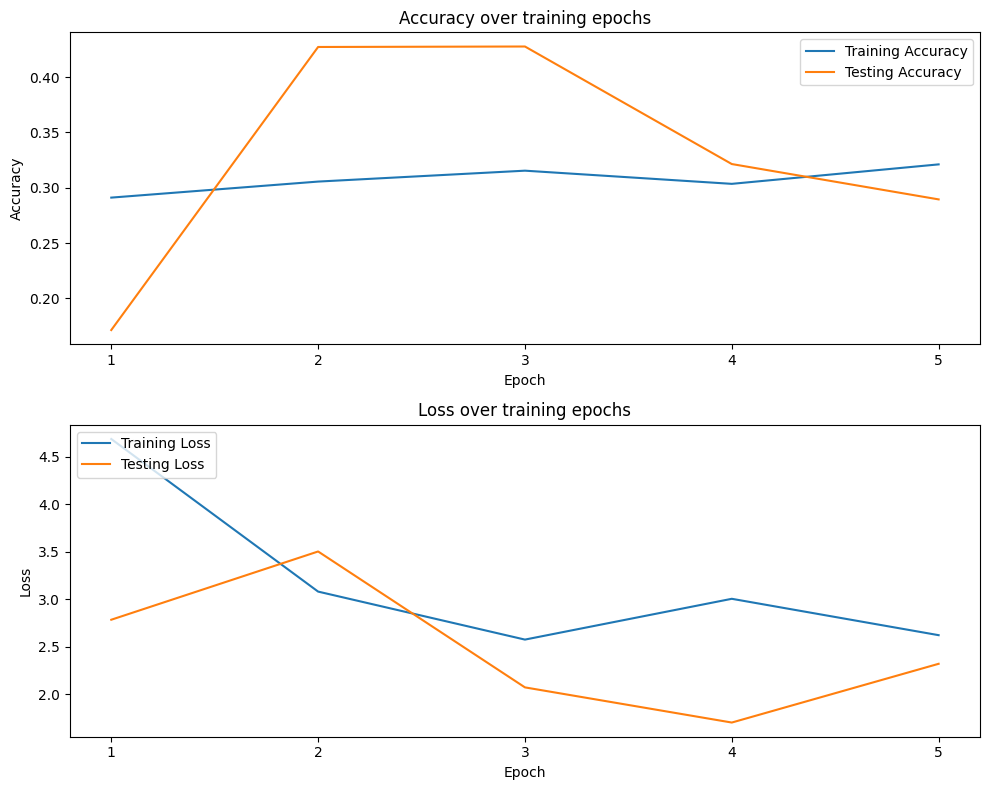

In [8]:
# Check out our train loss and test loss over epochs.
train_loss_resnet = history_resnet.history['loss']
test_loss_resnet = history_resnet.history['val_loss']
train_acc_resnet = history_resnet.history['accuracy']
test_acc_resnet = history_resnet.history['val_accuracy']

# Set figure size.
fig, axes = plt.subplots(nrows=2, figsize=(10,8))

# Generate line plot of training, testing loss over epochs.
axes[0].plot(train_acc_resnet, label='Training Accuracy')
axes[0].plot(test_acc_resnet, label='Testing Accuracy')
axes[0].set_title("Accuracy over training epochs")
axes[0].legend();
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(np.arange(len(test_acc_resnet)), np.arange(1, len(test_acc_resnet)+1))

axes[1].plot(train_loss_resnet, label='Training Loss')
axes[1].plot(test_loss_resnet, label='Testing Loss')
axes[1].set_title("Loss over training epochs")
axes[1].legend();
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_xticks(np.arange(len(test_acc_resnet)), np.arange(1, len(test_acc_resnet)+1))

# Set title
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

##### The results are not as good as VGGFace.

### 2.4 Evaluation of base models

##### The combined results for baseline models are:

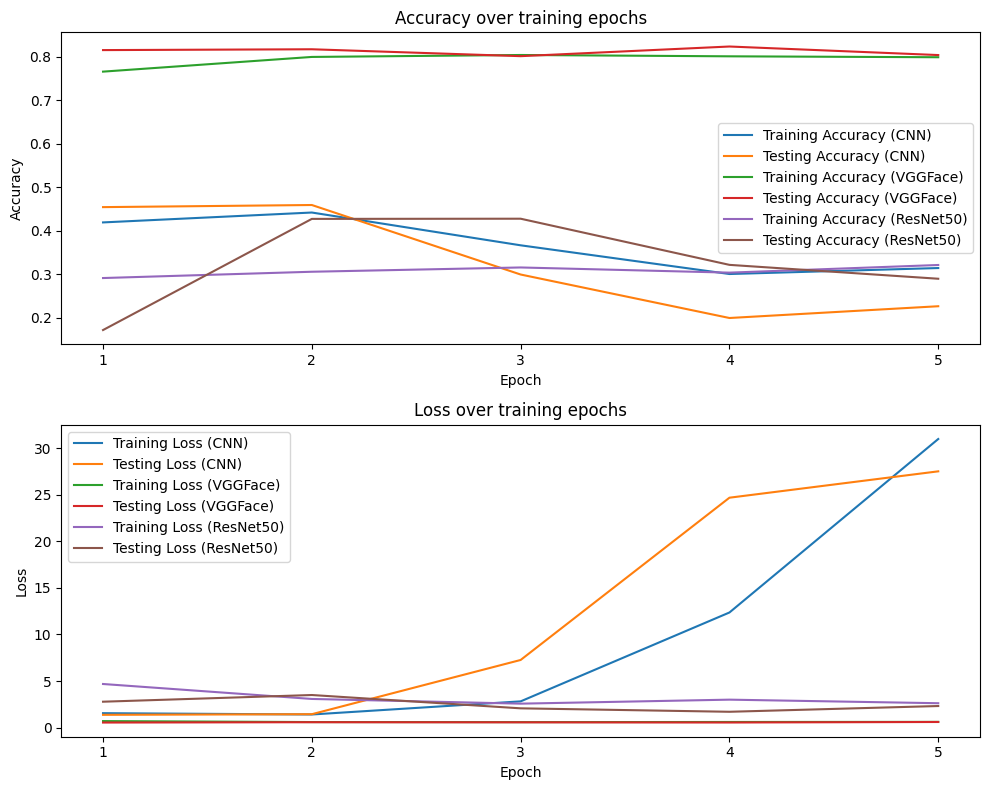

In [10]:
# Set figure size.
fig, axes = plt.subplots(nrows=2, figsize=(10,8))

# Generate line plot of training, testing loss over epochs.
# Accuracy
axes[0].plot(train_acc_cnn, label='Training Accuracy (CNN)')
axes[0].plot(test_acc_cnn, label='Testing Accuracy (CNN)')
axes[0].plot(train_acc_vgg, label='Training Accuracy (VGGFace)')
axes[0].plot(test_acc_vgg, label='Testing Accuracy (VGGFace)')
axes[0].plot(train_acc_resnet, label='Training Accuracy (ResNet50)')
axes[0].plot(test_acc_resnet, label='Testing Accuracy (ResNet50)')

axes[0].set_title("Accuracy over training epochs")
axes[0].legend();
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(np.arange(len(test_acc_resnet)), np.arange(1, len(test_acc_resnet)+1))

# Loss
axes[1].plot(train_loss_cnn, label='Training Loss (CNN)')
axes[1].plot(test_loss_cnn, label='Testing Loss (CNN)')
axes[1].plot(train_loss_vgg, label='Training Loss (VGGFace)')
axes[1].plot(test_loss_vgg, label='Testing Loss (VGGFace)')
axes[1].plot(train_loss_resnet, label='Training Loss (ResNet50)')
axes[1].plot(test_loss_resnet, label='Testing Loss (ResNet50)')

axes[1].set_title("Loss over training epochs")
axes[1].legend();
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_xticks(np.arange(len(test_acc_resnet)), np.arange(1, len(test_acc_resnet)+1))

# Set title
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

| Model         | Train Accuracy |  Validation Accuracy |
|:-------------:|:--------:|:--------:|
| CNN            |  0.3141    |  0.2262  |
| VGGFace |  0.7993    |  0.8043  |
| ResNet 50       |  0.3211    |  0.2895  |

##### Based on the results above, VGGFace performed the best hence it is chosen to further tuning.

##### VGGFace has the highest accuracy and lowest loss.

## 3. Hyperparameter tuning - VGGFace

##### I tried many different parameters to tune the VGGFace model for better performance.

##### The following is the best performance:
- using regularisation (dropout and batch normalisation)
- increase the training epochs to 30 with early stopping

In [23]:
# Create our FNN model architecture
model_vgg_opt = Sequential()

# Add the pre-trained model (VGGFace)
model_vgg_opt.add(pre_trained_vgg)

# Flatten the VGG16 output
model_vgg_opt.add(Flatten())

# Add dense layers with dropout
model_vgg_opt.add(Dense(128, activation='relu'))
model_vgg_opt.add(BatchNormalization())
model_vgg_opt.add(Dropout(0.5))

# Output layer for binary classification (gender)
model_vgg_opt.add(Dense(5, activation='softmax'))

model_vgg_opt.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vggface_vgg16 (Functional)  (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_9 (Dense)             (None, 128)               3211392   
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 5)                 645       
                                                      

##### Adding early stopping:

In [24]:
# Instantiating EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0,
                           patience=5,
                           mode='auto')

In [25]:
# Compile the model (same as what we've been doing before)
opt = Adam(learning_rate=0.001) # specify Adam optimizer
model_vgg_opt.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) # (same as what we've been doing before)

In [26]:
# Fit model on training data (fit model and save results to history)
history_vgg_opt = model_vgg_opt.fit(train_data, # train_data created using ImageDataGenerator class for model training (X, y split internally)
                        batch_size=32, # hyperparameter to tune
                        validation_data=val_data, # val_data created using ImageDataGenerator class for model validation (X, y split internally)
                        epochs=30, # generally less than 5 is sufficient when using transfer learning!
                        callbacks=[early_stop] # adding early stopping
                       )

Epoch 1/30
594/594 [==============================] - 1016s 2s/step - loss: 0.8260 - accuracy: 0.7272 - val_loss: 0.5460 - val_accuracy: 0.8146
Epoch 2/30
594/594 [==============================] - 960s 2s/step - loss: 0.6658 - accuracy: 0.7751 - val_loss: 0.5245 - val_accuracy: 0.8267
Epoch 3/30
594/594 [==============================] - 963s 2s/step - loss: 0.6376 - accuracy: 0.7840 - val_loss: 0.5206 - val_accuracy: 0.8248
Epoch 4/30
594/594 [==============================] - 975s 2s/step - loss: 0.6112 - accuracy: 0.7906 - val_loss: 0.5161 - val_accuracy: 0.8305
Epoch 5/30
594/594 [==============================] - 499s 839ms/step - loss: 0.6060 - accuracy: 0.7937 - val_loss: 0.4978 - val_accuracy: 0.8301
Epoch 6/30
594/594 [==============================] - 441s 743ms/step - loss: 0.6040 - accuracy: 0.7911 - val_loss: 0.4994 - val_accuracy: 0.8354
Epoch 7/30
594/594 [==============================] - 438s 738ms/step - loss: 0.5977 - accuracy: 0.7990 - val_loss: 0.5092 - val_accura

##### The early stopping kicked in at 28th epoch.

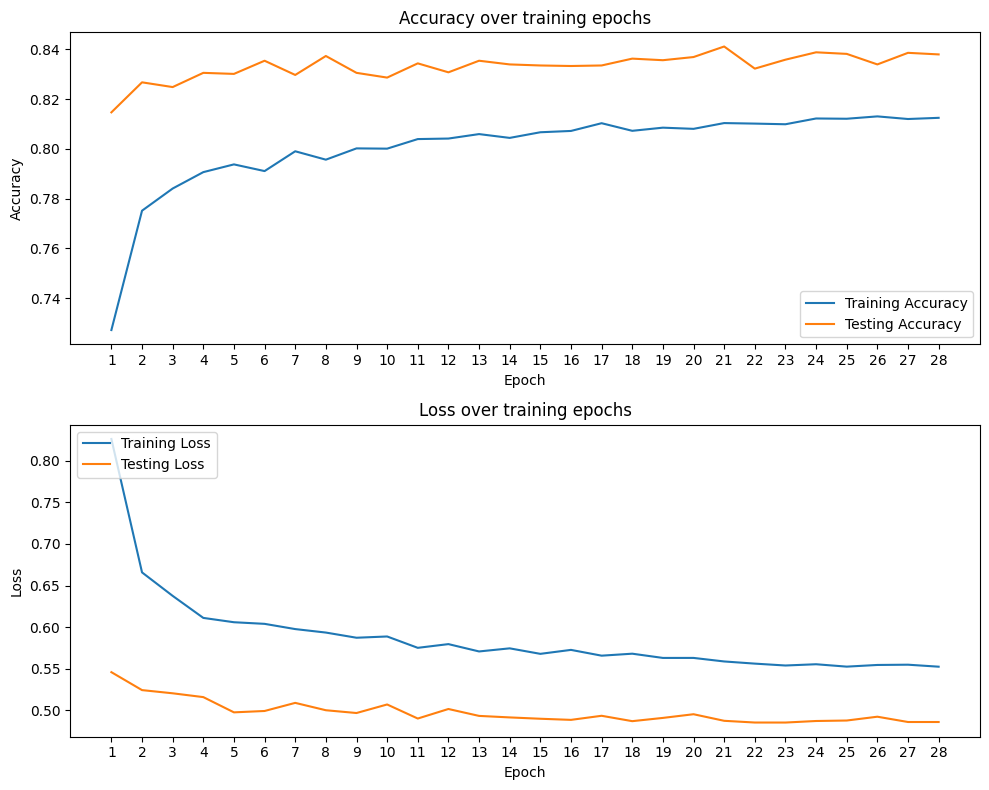

In [11]:
# Check out our train loss and test loss over epochs.
train_loss_vgg_opt = history_vgg_opt.history['loss']
test_loss_vgg_opt = history_vgg_opt.history['val_loss']
train_acc_vgg_opt = history_vgg_opt.history['accuracy']
test_acc_vgg_opt = history_vgg_opt.history['val_accuracy']

# Set figure size.
fig, axes = plt.subplots(nrows=2, figsize=(10,8))

# Generate line plot of training, testing loss over epochs.
axes[0].plot(train_acc_vgg_opt, label='Training Accuracy')
axes[0].plot(test_acc_vgg_opt, label='Testing Accuracy')
axes[0].set_title("Accuracy over training epochs")
axes[0].legend();
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(np.arange(len(test_acc_vgg_opt)), np.arange(1, len(test_acc_vgg_opt)+1))

axes[1].plot(train_loss_vgg_opt, label='Training Loss')
axes[1].plot(test_loss_vgg_opt, label='Testing Loss')
axes[1].set_title("Loss over training epochs")
axes[1].legend();
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_xticks(np.arange(len(test_acc_vgg_opt)), np.arange(1, len(test_acc_vgg_opt)+1))

# Set title
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

##### Based on the result above, early stopping kicked in at 28th epoch. The result after tuning is better. I will compare the result below.

---

##### Save the models before proceeding to the next section

In [ ]:
# save history record
plot_data = []
for model in ['cnn','vgg','resnet','vgg_opt']:
    for metric in ['train_loss_','test_loss_','train_acc_','test_acc_']:
        plot_data.append(metric+model)

df_history = pd.DataFrame({'name':plot_data,'history':[globals()[x] for x in plot_data]})
df_history.to_csv("../models/df_history_race.csv")
df_history


In [29]:
# Export the latest model to keras file
keras.models.save_model(model_vgg_opt,"../models/model_race.keras")

In [12]:
# import the keras file
race_model = tf.keras.models.load_model('../models/model_race.keras')

2024-05-06 16:26:28.994615: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-06 16:26:28.994737: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-05-06 16:26:28.994767: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-05-06 16:26:28.995337: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-06 16:26:28.996181: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## 4. Model evaluation after tuning - VGGFace

##### Race classes as below:-

In [13]:
# check the classes for imported data
train_data.class_indices

{'Asian': 0, 'Black': 1, 'Indian': 2, 'Others': 3, 'White': 4}

##### To evaluate the result, I added the prediction result to dataframe.

In [14]:
# separate test dataframe
df_test = df_main[df_main.train_test == 1]
df_test.head()

,filename,age,gender,race,age_range,train_test
2,86_1_0_20170120225751953.jpg.chip.jpg,86,Female,White,71-120,1
9,36_0_3_20170119180245724.jpg.chip.jpg,36,Male,Indian,31-40,1
10,58_0_2_20170116193704928.jpg.chip.jpg,58,Male,Asian,51-60,1
11,6_1_0_20170114024512634.jpg.chip.jpg,6,Female,White,0-10,1
12,35_1_2_20170116185947151.jpg.chip.jpg,35,Female,Asian,31-40,1


##### The model prediction output is the class code. As such I am creating the function below to convert to race.

In [15]:
# Create a function to make prediction based on the final model

def predict_race_series(filename):
    # read the images
    image = cv2.imread(os.path.join("../datasets/utkface", filename))
    image = cv2.resize(image, (224,224))
    image = np.expand_dims(image, axis=0) / 255.0

    # Predict race
    race = np.argmax(race_model.predict(image))
    race_classes = train_data.class_indices

    for bucket, num in race_classes.items():
        if race == num: return bucket

##### Adding predicted results for the validation data to a new dataframe

In [16]:
# Adding prediction to dataframe
df_test['race_predict'] = df_test['filename'].apply(predict_race_series)

1/1 [==============================] - 0s 317ms/step


2024-05-06 16:26:39.877522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 13ms/step


/var/folders/p4/69_wbmy1275g6vc8jw1vvhf00000gn/T/ipykernel_5576/504050006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['race_predict'] = df_test['filename'].apply(predict_race_series)


In [17]:
df_test.head()

,filename,age,gender,race,age_range,train_test,race_predict
2,86_1_0_20170120225751953.jpg.chip.jpg,86,Female,White,71-120,1,White
9,36_0_3_20170119180245724.jpg.chip.jpg,36,Male,Indian,31-40,1,Indian
10,58_0_2_20170116193704928.jpg.chip.jpg,58,Male,Asian,51-60,1,Asian
11,6_1_0_20170114024512634.jpg.chip.jpg,6,Female,White,0-10,1,White
12,35_1_2_20170116185947151.jpg.chip.jpg,35,Female,Asian,31-40,1,Asian


### 4.1 Metrics

##### Evaluate all the models based on metrics.

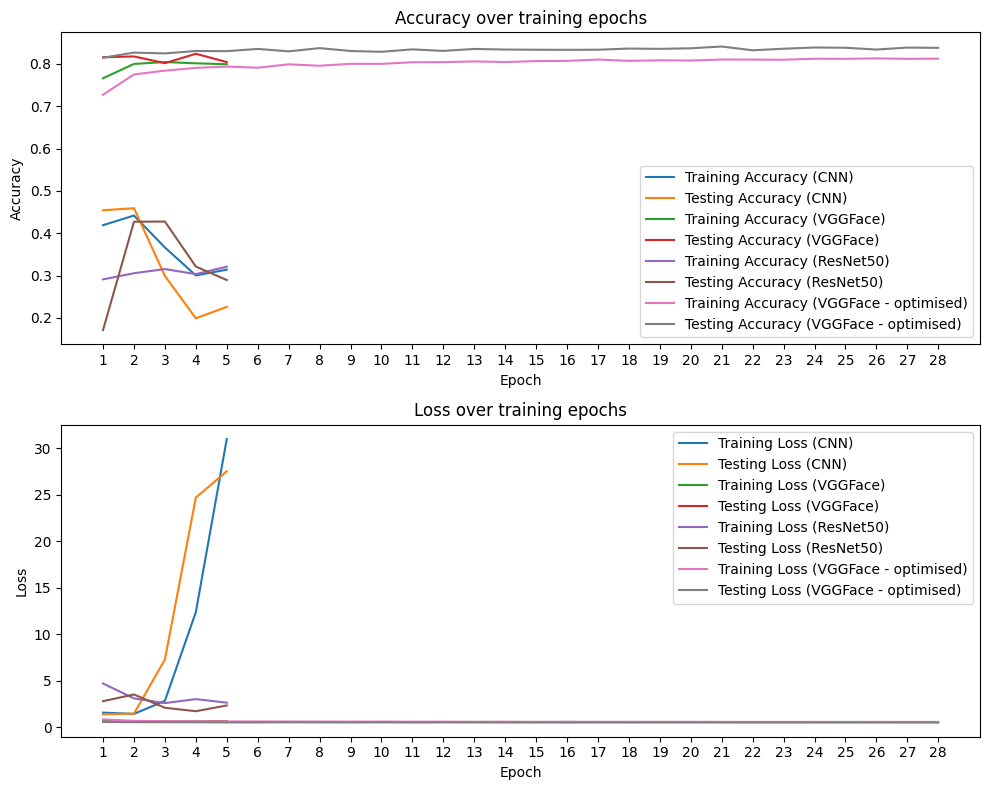

In [28]:
# Set figure size.
fig, axes = plt.subplots(nrows=2, figsize=(10,8))

# Generate line plot of training, testing loss over epochs.
# Accuracy
axes[0].plot(train_acc_cnn, label='Training Accuracy (CNN)')
axes[0].plot(test_acc_cnn, label='Testing Accuracy (CNN)')
axes[0].plot(train_acc_vgg, label='Training Accuracy (VGGFace)')
axes[0].plot(test_acc_vgg, label='Testing Accuracy (VGGFace)')
axes[0].plot(train_acc_resnet, label='Training Accuracy (ResNet50)')
axes[0].plot(test_acc_resnet, label='Testing Accuracy (ResNet50)')
axes[0].plot(train_acc_vgg_opt, label='Training Accuracy (VGGFace - optimised)')
axes[0].plot(test_acc_vgg_opt, label='Testing Accuracy (VGGFace - optimised)')

axes[0].set_title("Accuracy over training epochs")
axes[0].legend();
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(np.arange(len(test_acc_vgg_opt)), np.arange(1, len(test_acc_vgg_opt)+1))

# Loss
axes[1].plot(train_loss_cnn, label='Training Loss (CNN)')
axes[1].plot(test_loss_cnn, label='Testing Loss (CNN)')
axes[1].plot(train_loss_vgg, label='Training Loss (VGGFace)')
axes[1].plot(test_loss_vgg, label='Testing Loss (VGGFace)')
axes[1].plot(train_loss_resnet, label='Training Loss (ResNet50)')
axes[1].plot(test_loss_resnet, label='Testing Loss (ResNet50)')
axes[1].plot(train_loss_vgg_opt, label='Training Loss (VGGFace - optimised)')
axes[1].plot(test_loss_vgg_opt, label='Testing Loss (VGGFace - optimised)')

axes[1].set_title("Loss over training epochs")
axes[1].legend();
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_xticks(np.arange(len(test_acc_vgg_opt)), np.arange(1, len(test_acc_vgg_opt)+1))

# Set title 
plt.tight_layout()
plt.show()

| Model         | Train Accuracy |  Validation Accuracy |
|:-------------:|:--------:|:--------:|
| CNN            |  0.3141    |  0.2262  |
| VGGFace |  0.7993    |  0.8043  |
| ResNet 50       |  0.3211    |  0.2895  |
| VGGFace (after tuning)      |  0.8124    |  0.8379  |

##### Based on the plot above, the tuned VGGFace model demonstrates the best performance with the highest accuracy and lowest loss.

##### Extending the training from 5 to 28 epochs further improved the model's performance.

---

##### We further evaluate the final VGG model with other metrics.

In [18]:
# Classification Report (including precision, recall)
print(classification_report(df_test.race, df_test.race_predict))

              precision    recall  f1-score   support

       Asian       0.89      0.92      0.90       642
       Black       0.87      0.90      0.89       942
      Indian       0.82      0.76      0.79       785
      Others       0.41      0.27      0.32       338
       White       0.86      0.92      0.89      2019

    accuracy                           0.84      4726
   macro avg       0.77      0.75      0.76      4726
weighted avg       0.83      0.84      0.83      4726



##### The performance based on the classification report is very good. We have approximately 0.83 for the weighted average in accuracy, precision, recall, and F1 score. This indicates that the model will aid in detecting gender with a high proportion of true predictions.

### 4.2 Confusion Matrix

##### Plotting the confusion matrix for validation data below:

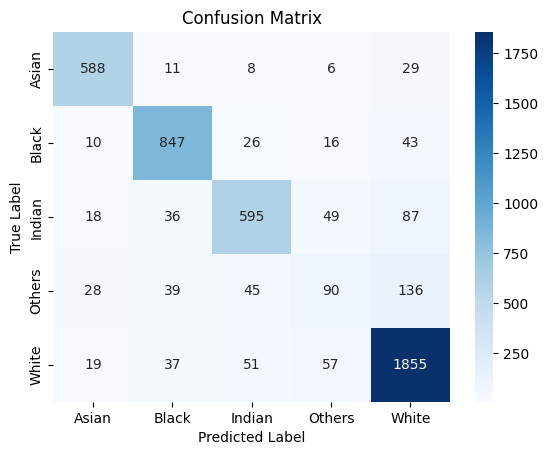

In [19]:
# Calculate the confusion matrix
cm = confusion_matrix(df_test.race.map(train_data.class_indices), df_test.race_predict.map(train_data.class_indices)) 

# Create a heatmap using Seaborn 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=['Asian', 'Black', 'Indian', 'Others', 'White'], yticklabels=['Asian', 'Black', 'Indian', 'Others', 'White']) # 'fmt='d' shows values as integers

# Labels, title, and ticks
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

##### The confusion matrix shows that the model mostly predicted correctly for all races.

### 4.3 Validation image with true and false prediction

##### To gain visual insight into the predictions, refer to the random sample of true and false prediction images below.

##### - True Prediction

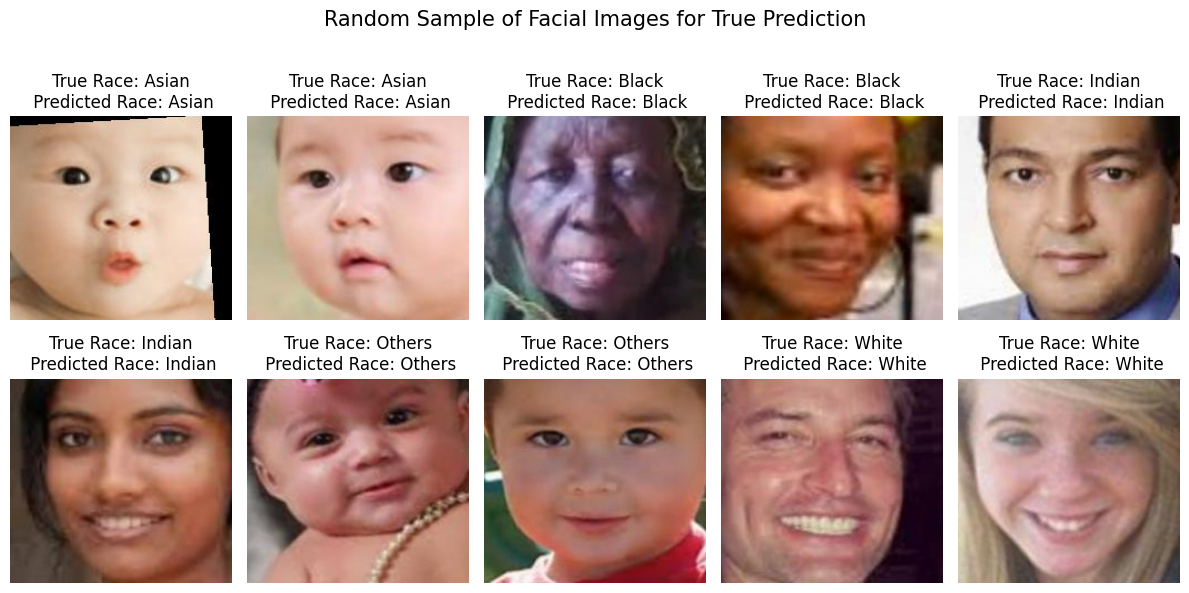

In [20]:
# set a subplot
fig, axes = plt.subplots(2, 5, figsize=(12, 6))


#randonly choose 8 images from correct prediction
img_list = []
for sample in ['Asian', 'Black', 'Indian', 'Others', 'White']:
    for _ in range(2):
        img_list.append(np.random.choice(df_test[(df_test.race == df_test.race_predict) & (df_test.race == sample)].filename))

# Load the image
nrow = 0
ncol = 0

for num, img in enumerate(img_list):
    image = imread(os.path.join("../datasets/utkface",img))

    # Display the image
    axes[nrow, ncol].imshow(image, cmap='gray', aspect='auto')
    axes[nrow, ncol].set_title(f"True Race: {df_test.loc[df_test.filename == img].race.values[0]}\n Predicted Race: {df_test.loc[df_test.filename == img].race_predict.values[0]}")
    axes[nrow, ncol].axis('off')

    ncol += 1
    if ncol == 5:
        nrow += 1
        ncol = 0

plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.suptitle("Random Sample of Facial Images for True Prediction",fontsize=15)
plt.show()

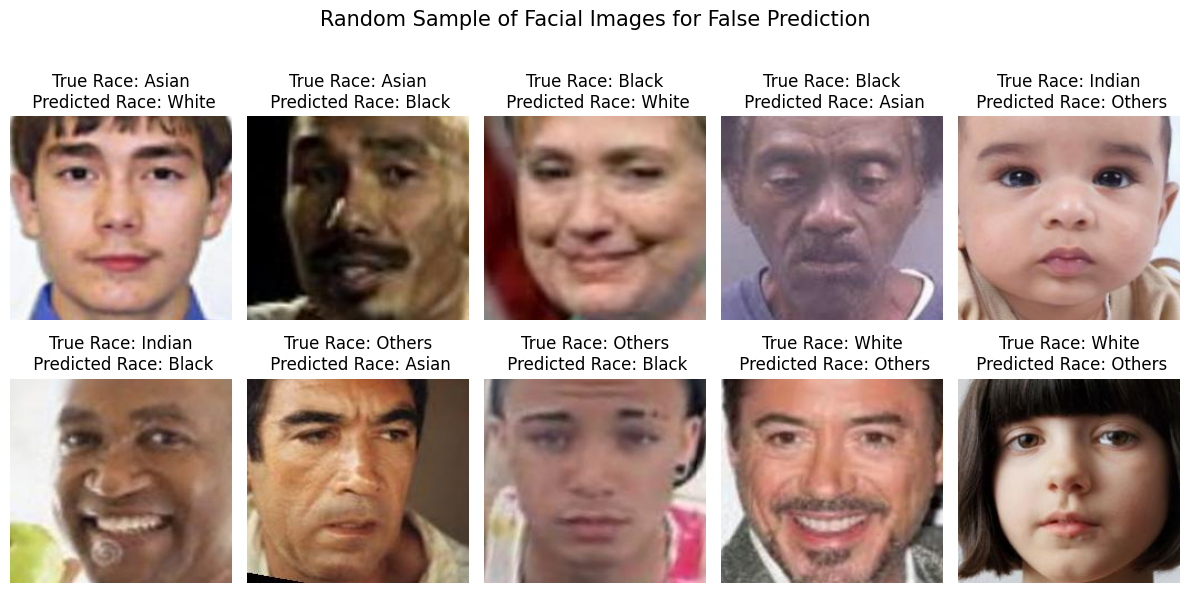

In [22]:
# set a subplot
fig, axes = plt.subplots(2, 5, figsize=(12, 6))


#randonly choose 8 images from False prediction
img_list = []
for sample in ['Asian', 'Black', 'Indian', 'Others', 'White']:
    for _ in range(2):
        img_list.append(np.random.choice(df_test[(df_test.race != df_test.race_predict) & (df_test.race == sample)].filename))

# Load the image
nrow = 0
ncol = 0

for num, img in enumerate(img_list):
    image = imread(os.path.join("../datasets/utkface",img))

    # Display the image
    axes[nrow, ncol].imshow(image, cmap='gray', aspect='auto')
    axes[nrow, ncol].set_title(f"True Race: {df_test.loc[df_test.filename == img].race.values[0]}\n Predicted Race: {df_test.loc[df_test.filename == img].race_predict.values[0]}")
    axes[nrow, ncol].axis('off')

    ncol += 1
    if ncol == 5:
        nrow += 1
        ncol = 0

plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.suptitle("Random Sample of Facial Images for False Prediction",fontsize=15)
plt.show()

##### The model performs very well and meets the criteria for being considered the final model for race classification.

---

##### Next, I will move to Notebook 2.2 to build a model for age classification.